In [6]:
"""

Integrated Gradients note book for VRDU models

"""

'\n\nIntegrated Gradients note book for VRDU models\n\n'

In [19]:
def to_fp16_where_possible(batch, device):
    out = {}
    for k, v in batch.items():
        if v.dtype.is_floating_point:      # only floats → half
            out[k] = v.half().to(device)
        else:                             # ints / bools stay as-is
            out[k] = v.to(device)
    return out

In [7]:
!find . -name "__pycache__" -exec rm -rf {} +

In [3]:
!pip uninstall datasets seqeval evaluate transformers torch captum y

In [ ]:
!pip uninstall torch torchvision torchaudio fastai -y
!pip uninstall datasets transformers evaluate captum seqeval -y

!pip install torch==2.6.0+cu124 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install datasets==3.4.0 transformers==4.38.2 evaluate==0.4.0 seqeval==1.2.2 captum==0.8.0

In [1]:
from PIL import Image, ImageDraw, ImageFont
import evaluate
from transformers import AutoProcessor, LayoutLMv3ForTokenClassification, set_seed
from datasets import load_dataset
import transformers as t
import torch
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


set_seed(0)


In [2]:
funsd = load_dataset("nielsr/funsd")
labels = funsd["train"].features["ner_tags"].feature.names
id2label = {v: k for v, k in enumerate(labels)}
label2id = {v: k for k, v in enumerate(labels)}
print(id2label)
print(label2id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}
{'O': 0, 'B-HEADER': 1, 'I-HEADER': 2, 'B-QUESTION': 3, 'I-QUESTION': 4, 'B-ANSWER': 5, 'I-ANSWER': 6}


In [16]:
model = LayoutLMv3ForTokenClassification.from_pretrained("adamadam111/layoutlmv3-finetuned-funsd", torch_dtype=torch.float16).to(device).eval()
try:
  processor = AutoProcessor.from_pretrained("adamadam111/layoutlmv3-finetuned-funsd")
  print("[Processor] - Loaded processor from 'adamadam111'")
except:
  processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
  print("[Processor] - Loaded processor from 'microsoft'")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[Processor] - Loaded processor from 'microsoft'


In [5]:
for name, module in model.named_modules():
    if 'embed' in name:
        print(name)

layoutlmv3.embeddings
layoutlmv3.embeddings.word_embeddings
layoutlmv3.embeddings.token_type_embeddings
layoutlmv3.embeddings.LayerNorm
layoutlmv3.embeddings.dropout
layoutlmv3.embeddings.position_embeddings
layoutlmv3.embeddings.x_position_embeddings
layoutlmv3.embeddings.y_position_embeddings
layoutlmv3.embeddings.h_position_embeddings
layoutlmv3.embeddings.w_position_embeddings
layoutlmv3.patch_embed
layoutlmv3.patch_embed.proj


In [6]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

In [120]:
sample = funsd["test"][0]

enc = processor(
    Image.open(sample["image_path"]).convert("RGB"),
    sample["words"],
    boxes=sample["bboxes"],
    word_labels=sample["ner_tags"],
    padding="max_length",
    return_tensors = 'pt'
).to(device)
token_to_word = enc.word_ids(batch_index=0)
enc = to_fp16_where_possible(enc, device)

with torch.no_grad():
  out = model(**enc)

pred_ids = out.logits.argmax(-1).squeeze()
print(len(pred_ids))
question_label_id = model.config.label2id["B-QUESTION"]

512


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [74]:
question_token_idx = (pred_ids == question_label_id).nonzero(as_tuple=True)[0]
print(question_token_idx[0].item())

1


In [23]:
def token_logit_forward(input_ids, bbox, pixel_values, attention_mask, token_index):
  logits = model(input_ids = input_ids,
                 bbox=bbox,
                 pixel_values=pixel_values,
                 attention_mask=attention_mask).logits

  return logits[:, token_index, question_label_id]

In [25]:
from captum.attr import LayerIntegratedGradients
lig = LayerIntegratedGradients(token_logit_forward, model.layoutlmv3.embeddings)

In [ ]:
print(question_token_idx)

In [27]:
from tqdm import tqdm
attributions = {}

pad_ids = enc["input_ids"].clone()
pad_ids[:] = processor.tokenizer.pad_token_id
pad_ids = pad_ids.to(device)

for idx in question_token_idx.tolist():
  attrs, delta = lig.attribute(
      inputs = enc["input_ids"],
      baselines = pad_ids,
      additional_forward_args = (enc["bbox"], enc["pixel_values"], enc["attention_mask"], idx),
      n_steps = 50,
      internal_batch_size = 4,
      return_convergence_delta = True)


  attributions[idx] = attrs.sum(-1).squeeze().detach().cpu()

## Attributions Investigation

### Aggregate sub word attributions to words

In [121]:
inp_ids = enc["input_ids"].squeeze()
print(token_to_word)
id2token = [tok.lstrip("Ġ") for tok in processor.tokenizer.convert_ids_to_tokens(inp_ids)] # Convert ids to tokens, strip prefix

[None, 0, 0, 1, 1, 1, 2, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 12, 13, 13, 14, 14, 15, 16, 16, 17, 17, 18, 18, 18, 19, 19, 20, 21, 22, 23, 23, 24, 25, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 33, 33, 34, 34, 35, 36, 36, 36, 37, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 41, 42, 42, 43, 43, 43, 44, 44, 44, 45, 45, 46, 46, 47, 47, 48, 49, 49, 50, 50, 51, 52, 52, 52, 53, 54, 55, 56, 57, 57, 58, 58, 58, 59, 59, 59, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 64, 65, 65, 65, 65, 66, 67, 68, 69, 70, 70, 70, 71, 72, 73, 74, 74, 75, 75, 75, 75, 76, 77, 77, 78, 78, 78, 79, 80, 80, 81, 82, 82, 82, 83, 84, 84, 84, 84, 85, 86, 86, 87, 88, 89, 90, 91, 92, 93, 93, 93, 93, 94, 95, 95, 96, 97, 97, 98, 99, 100, 100, 100, 100, 101, 102, 103, 103, 104, 105, 106, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 109, 110, 110, 110, 111, 112, 112, 112, 112, 113, 114, 114, 115, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128

In [123]:
for target_idx, token_ig in attributions.items():
  word_score = {}
  for tok_idx, word_idx in enumerate(token_to_word):
    if word_idx is None:
      continue
    word_score[word_idx] = word_score.get(word_idx, 0.0) + token_ig[tok_idx].item()

print(word_score)

{0: 0.15432224422693253, 1: 0.276475265622139, 2: 0.011884822510182858, 3: 0.008842009759973735, 4: 0.14556000754237175, 5: 0.11706143617630005, 6: 0.0009165612864308059, 7: 0.0040055993013083935, 8: -0.011751435697078705, 9: 0.003732158336788416, 10: 0.004989351145923138, 11: 0.011240002233535051, 12: 0.008887242525815964, 13: 0.022714215330779552, 14: 0.01578154508024454, 15: -0.005942930467426777, 16: 0.0462995283305645, 17: -0.001224731095135212, 18: -0.017338583944365382, 19: 0.0178151810541749, 20: 0.07117278128862381, 21: 0.013726618140935898, 22: 0.029353782534599304, 23: -0.024514023680239916, 24: -0.022772371768951416, 25: 0.08536695688962936, 26: -0.012950081145390868, 27: -0.023703754879534245, 28: -0.0068933176808059216, 29: -0.001447996124625206, 30: -0.030546701978892088, 31: -0.007306845858693123, 32: -0.009140182752162218, 33: -0.006268301163800061, 34: -0.004259791108779609, 35: -0.030059585347771645, 36: 0.023937189485877752, 37: -0.03732180781662464, 38: -0.02384913

In [95]:
for idx, att in attributions.items():
  target_token = processor.tokenizer.decode(inp_ids[idx])
  top_pos_att_idx = torch.argmax(att).item()
  top_neg_att_idx = torch.argmin(att).item()
  print("-"*15)
  print(f"Target Token: {target_token}")
  print(f"Top Positive Attributing Token: {id2token[top_pos_att_idx]} {att[top_pos_att_idx]}")
  print(f"Top Negatve Attributing Token: {id2token[top_neg_att_idx]} {att[top_neg_att_idx]}")


---------------
Target Token:  TO
Top Positive Attributing Token: <s> 0.29470646381378174
Top Negatve Attributing Token: : -0.4752565324306488
---------------
Target Token: :
Top Positive Attributing Token: ATE 0.5630208253860474
Top Negatve Attributing Token: : -1.2728767395019531
---------------
Target Token:  D
Top Positive Attributing Token: <s> 0.15844020247459412
Top Negatve Attributing Token: : -0.3868783116340637
---------------
Target Token: ATE
Top Positive Attributing Token: <s> 0.6345909833908081
Top Negatve Attributing Token: ATE -0.5552409291267395
---------------
Target Token:  NOTE
Top Positive Attributing Token: : 0.21628065407276154
Top Negatve Attributing Token: : -0.5226317048072815
---------------
Target Token: :
Top Positive Attributing Token: </s> 0.4335537850856781
Top Negatve Attributing Token: : -1.0101975202560425
---------------
Target Token:  FA
Top Positive Attributing Token: FA 2.101177215576172
Top Negatve Attributing Token: 392 -0.28232231736183167
----

### Global question heatmap

*   Aggregate ig scores across all question tokens
*   display overlay on sample image

In [151]:
global_word_score = {}

for ques_token in attributions.values():
  for tok_idx, w_idx in enumerate(token_to_word):
    if w_idx is None:
      continue
    global_word_score[w_idx] = (
        global_word_score.get(w_idx, 0.0) +
        ques_token[tok_idx].item()
    )

print(global_word_score)

{0: 0.8996986858546734, 1: 5.153170995414257, 2: 0.5943908044137061, 3: -0.6462457334273495, 4: -0.9922473409678787, 5: -0.8018712452612817, 6: -0.39956047042505816, 7: -0.47767927474342287, 8: -0.5468314228346571, 9: 0.08680502348579466, 10: -0.10857629822567105, 11: -0.23392890498507768, 12: -0.06995277758687735, 13: 0.15261135145556182, 14: 0.31703311088494956, 15: -0.14715155656449497, 16: 0.6170198698528111, 17: -0.616740389727056, 18: -0.7942215723451227, 19: -0.16292382264509797, 20: 0.6106757302768528, 21: -0.36624852498061955, 22: -0.00831044651567936, 23: -1.88938240846619, 24: -0.5489999493584037, 25: 0.2387544906232506, 26: -0.12636718794237822, 27: -0.3837013158481568, 28: -0.463318289257586, 29: -0.39937731588725, 30: -0.3509880435594823, 31: 0.06536353041883558, 32: -1.2435919496929273, 33: 6.373162513016723, 34: 5.043274540803395, 35: -0.21455719810910523, 36: -1.109260513796471, 37: 0.15232581202872097, 38: -0.5535569487838075, 39: -1.2585270653944463, 40: 3.4200371876

Normalize for colouring

In [152]:
def px_box_of(word_idx):
    w,h = page.size
    scale = [w/1000, h/1000, w/1000, h/1000]
    bx = sample["bboxes"][word_idx]
    return tuple(int(b*s) for b,s in zip(bx, scale))

In [153]:
max_score = max(global_word_score.values())
for w in global_word_score:
    global_word_score[w] /= max_score

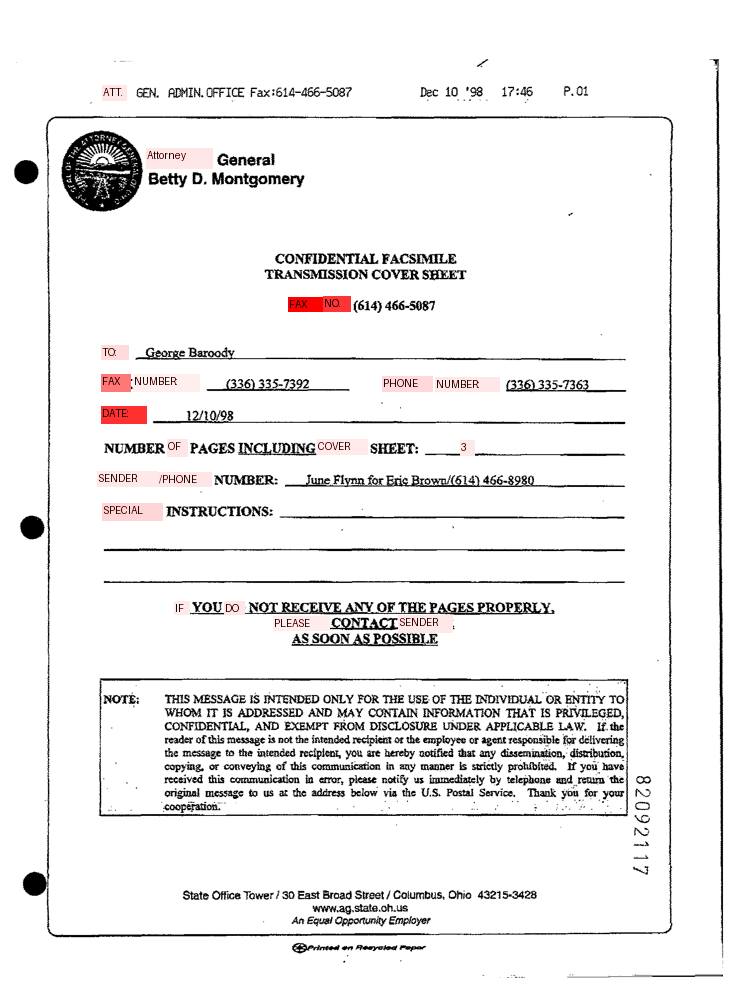

In [174]:
from PIL import Image, ImageDraw

page   = Image.open(sample["image_path"]).convert("RGBA")
draw   = ImageDraw.Draw(page, "RGBA")
w, h   = page.size
scale  = [w/1000, h/1000, w/1000, h/1000]   # LayoutLM boxes → px

for w_idx, score in global_word_score.items():
    if score < 0.05:                        # hide low-importance words
        continue
    box = sample["bboxes"][w_idx]           # FUNSD box in 0-1000 coords
    px_box = tuple(int(b*s) for b, s in zip(box, scale))
    alpha = int(255 * score)                # deeper red ↔ higher score
    draw.rectangle(px_box, fill=(255, 0, 0, alpha))
    draw.text((px_box[0]+1, px_box[1]+1), sample["words"][w_idx],
          fill=(0,0,0,255))
page

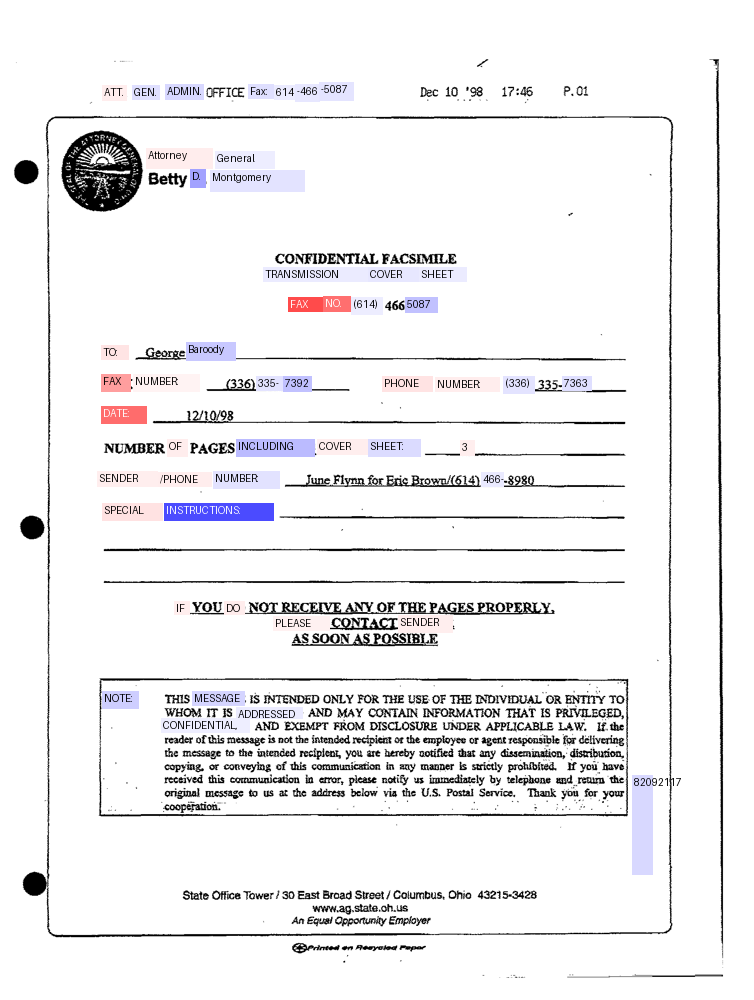

In [175]:
import matplotlib.pyplot as plt
from matplotlib import colors, colormaps
draw = ImageDraw.Draw(page, "RGBA")          # fresh canvas

vals = list(global_word_score.values())
lo, hi = min(vals), max(vals)

if lo < 0 < hi:                              # mixed signs → diverging
    norm = colors.TwoSlopeNorm(vmin=lo, vcenter=0, vmax=hi)
    cmap = colormaps["bwr"]                  # blue-white-red
else:                                        # all same sign
    norm = colors.Normalize(vmin=lo, vmax=hi)
    cmap = colormaps["Reds"] if hi > 0 else colormaps["Blues_r"]

threshold = 0.05 * max(abs(lo), abs(hi))         # 5 % cut-off
alpha     = 180                                  # constant transparency

for w_idx, score in global_word_score.items():
    if abs(score) < threshold:
        continue
    box = px_box_of(w_idx)

    r, g, b, _ = cmap(norm(score))
    rgba = (int(255*r), int(255*g), int(255*b), alpha)
    draw.rectangle(box, fill=rgba)

    # decide black or white text by luminance of rectangle colour
    luminance = 0.299*r + 0.587*g + 0.114*b
    txt_colour = (0,0,0,255) if luminance > 0.5 else (255,255,255,255)

    draw.text((box[0]+2, box[1]+1), sample["words"][w_idx],fill=txt_colour)
page